C:\Users\littl\anaconda3\envs\thesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Results saved to ../data/final/nicu_30_cb_data.csv


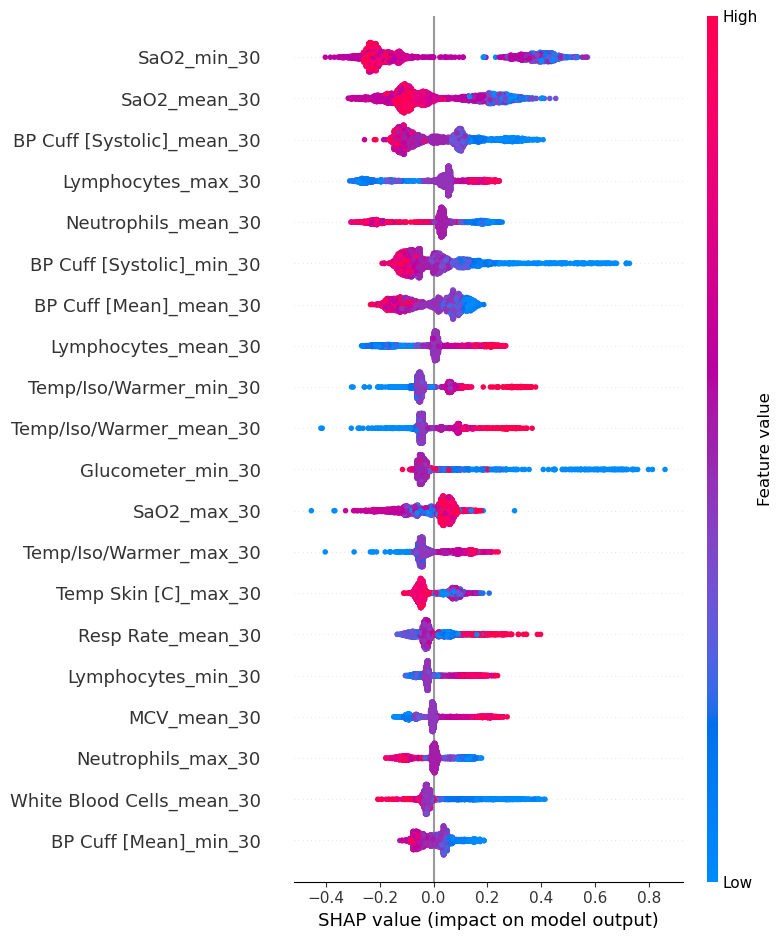

In [1]:
import pandas as pd
import shap
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier

def run_catboost_grid_search(data: pd.DataFrame,
                             target: str,
                             drop_threshold: float = 0.75,
                             max_iter_mice: int = 12,
                             n_splits: int = 5,
                             random_state: int = 42,
                             output_csv: str = "../data/final/nicu_30_cb_data.csv"):
    """
    Perform CatBoost grid search with MICE imputation, then output top 15 models' metrics
    including hyperparameters, CV score, precision, recall, f1-score, and accuracy.
    Also output feature importances and SHAP values for the best model.

    :param data: Input dataframe including the target column.
    :param target: Name of the target column.
    :param drop_threshold: Rows with missing ratio above this will be dropped (default=0.95).
    :param max_iter_mice: Iterations for IterativeImputer (MICE) (default=12).
    :param n_splits: Number of folds for cross-validation (default=5).
    :param random_state: Seed for reproducibility (default=42).
    :param output_csv: Path to save the results CSV file.
    :return: Trained best CatBoostClassifier model (after grid search).
    """
    # Drop rows with too many missing values
    row_missing_ratio = data.isnull().sum(axis=1) / data.shape[1]
    data_cleaned = data.loc[row_missing_ratio <= drop_threshold].copy()
    
    # Separate features (X) and target (y)
    y = data_cleaned[target]
    X = data_cleaned.drop(columns=[target])
    feature_names = X.columns  # Keep feature names for later use

    # MICE imputation
    imputer = IterativeImputer(max_iter=max_iter_mice, random_state=random_state)
    X_imputed = imputer.fit_transform(X)
    
    # Define a parameter grid for CatBoostClassifier
    param_grid = {
        "iterations": [100, 200, 300],
        "learning_rate": [0.01, 0.05, 0.1],
        "depth": [4, 6, 8],
        "l2_leaf_reg": [1, 3, 5],
        "border_count": [32, 64, 128]
    }
    
    # Initialize the base model
    catboost = CatBoostClassifier(random_state=random_state, verbose=0)
    
    # Grid Search with StratifiedKFold cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    grid_search = GridSearchCV(
        estimator=catboost,
        param_grid=param_grid,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_imputed, y)

    # Retrieve top 15 results
    cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(by="mean_test_score", ascending=False).head(15)
    
    # Store model performance results
    results = []

    for rank, (_, row) in enumerate(cv_results.iterrows(), start=1):
        params = row["params"]
        mean_cv_score = row["mean_test_score"]

        # Train model with best parameters
        model = CatBoostClassifier(random_state=random_state, verbose=0, **params)
        model.fit(X_imputed, y)

        # Predict on the same dataset for demonstration
        y_pred = model.predict(X_imputed)

        # Compute classification metrics
        report = classification_report(y, y_pred, output_dict=True)
        precision = report["weighted avg"]["precision"]
        recall = report["weighted avg"]["recall"]
        f1_score = report["weighted avg"]["f1-score"]
        accuracy = report["accuracy"]

        # Store results
        results.append({
            "Rank": rank,
            "Hyperparameters": str(params),
            "CV_Score": mean_cv_score,
            "Precision": precision,
            "Recall": recall,
            "F1_Score": f1_score,
            "Accuracy": accuracy
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Export to CSV
    results_df.to_csv(output_csv, index=False)
    print(f"Results saved to {output_csv}")
    
    # Retrieve the best estimator
    best_model = grid_search.best_estimator_

    # Compute SHAP values for the best model
    explainer = shap.Explainer(best_model)
    shap_values = explainer(X_imputed)
    
    # Summary plot (if running in a notebook, this will display inline)
    shap.summary_plot(shap_values, X_imputed, feature_names=feature_names)

    return best_model

# Run the function with your dataset
file_path = "../data/final/nicu_30.csv"
data = pd.read_csv(file_path).drop(columns=['SUBJECT_ID'])

target_column = "is_infected"

best_model = run_catboost_grid_search(
    data=data,
    target=target_column,
    drop_threshold=0.75,
    max_iter_mice=12,
    output_csv="../data/final/nicu_30_cb_data.csv"
)
